# Loading the Datasets

In [1]:
from Model import *
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from statistics import mean

#get the data
split_ratio = 0.8
val_ratio = 0.2
data = pd.read_csv("Data/dataset_multilabel.csv", dtype = str)
train_df = data.sample(frac = split_ratio)
test_df = data.drop(train_df.index)
val_df = train_df.sample(frac = val_ratio)
train_df = train_df.drop(val_df.index)

train_dataset = QueueDataset(train_df)
test_dataset = QueueDataset(test_df)
val_dataset = QueueDataset(val_df)

#initialize the data loader 
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = True)

# Defining the Model

In [4]:
#model hyperparameters 
ntokens = 65536  # size of vocabulary
emsize = 240  # embedding dimension
d_hid = 240  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 1  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 1  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

#define the model 
device = "cpu"
transformer = RandomLM(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(transformer.parameters())

/Users/rishabhgoel/Environments/Randomness_Testing/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Training Model

In [5]:
train_losses = []
train_macro = []
train_micro = []
train_sample = []
train_weighted = []

val_losses = []
val_macro = []
val_micro = []
val_sample = []
val_weighted = []

batch_num = []

for epoch in range(3):
    transformer.train()

    train_losses_per_100 = []
    train_macro_per_100 = []
    train_micro_per_100 = []
    train_sample_per_100 = []
    train_weighted_per_100 = []

    val_losses_per_100 = []
    val_macro_per_100 = []
    val_micro_per_100 = []
    val_sample_per_100 = []
    val_weighted_per_100 = []

    for i, data in enumerate(train_loader):
        #get the data
        queues, labels = data
        queues = queues.to(device)
        labels = labels.to(device)

        #forward pass
        optimizer.zero_grad()
        output = transformer(queues)
        loss = criterion(output, labels)

        #backward pass
        loss.backward()
        optimizer.step()

        #metrics
        macro, micro, sample, weighted = F_score(output, labels)

        train_losses_per_100.append(loss.item())
        train_macro_per_100.append(macro)
        train_micro_per_100.append(micro)
        train_sample_per_100.append(sample)
        train_weighted_per_100.append(weighted)

        #every 100 batches, log metrics and run validation
        if (i+1) % 100 == 0:
            train_losses.append(np.array(train_losses_per_100).mean())
            train_macro.append(np.array(train_macro_per_100).mean())
            train_micro.append(np.array(train_micro_per_100).mean())
            train_sample.append(np.array(train_sample_per_100).mean())
            train_weighted.append(np.array(train_weighted_per_100).mean())

            train_losses_per_100 = []
            train_macro_per_100 = []
            train_micro_per_100 = []
            train_sample_per_100 = []
            train_weighted_per_100 = []

            batch_num.append((i + 1) + (epoch) * (600))

            #validate the model
            transformer.eval()
            for i, data in enumerate(val_loader):
                queues, labels = data
                queues = queues.to(device)
                labels = labels.to(device)

                #forward pass
                output = transformer(queues)
                loss = criterion(output, labels)

                #metrics
                macro, micro, sample, weighted = F_score(output, labels)

                val_losses_per_100.append(loss.item())
                val_macro_per_100.append(macro)
                val_micro_per_100.append(micro)
                val_sample_per_100.append(sample)
                val_weighted_per_100.append(weighted)

            val_losses.append(np.array(val_losses_per_100).mean())
            val_macro.append(np.array(val_macro_per_100).mean())
            val_micro.append(np.array(val_micro_per_100).mean())
            val_sample.append(np.array(val_sample_per_100).mean())
            val_weighted.append(np.array(val_weighted_per_100).mean())
            
            val_losses_per_100 = []
            val_macro_per_100 = []
            val_micro_per_100 = []
            val_sample_per_100 = []
            val_weighted_per_100 = []
            
            print("epoch: {}, batch: {}, train loss: {}, train macro: {}, train micro: {}, train sample: {}, train weighted {}, val loss: {}, val macro: {}, val micro: {} val sample: {} val weighted: {}".format(
                epoch + 1, i + 1, train_losses[-1], train_macro[-1], train_micro[-1], train_sample[-1], train_weighted[-1], val_losses[-1], val_macro[-1], val_micro[-1], val_sample[-1], val_weighted[-1])
            )
            transformer.train()

epoch: 1, batch: 161, train loss: 0.6093571171164512, train macro: 0.8142823816839243, train micro: 0.8440832828469962, train sample: 0.755828070800727, train weighted 0.8295287886500621, val loss: 0.23912990963236885, val macro: 0.9325017599470422, val micro: 0.9350682629005513 val sample: 0.8302336850327121 val weighted: 0.9351879781525473
epoch: 1, batch: 161, train loss: 0.2041199231147766, train macro: 0.9411030093686226, train micro: 0.9431553556129474, train sample: 0.8465071417297979, train weighted 0.943245801754601, val loss: 0.17878093936058306, val macro: 0.9504039089218796, val micro: 0.9521213759456401 val sample: 0.8697271980302204 val weighted: 0.9520984307702691
epoch: 1, batch: 161, train loss: 0.1749975351989269, train macro: 0.9495365990504131, train micro: 0.9509599669341003, train sample: 0.8610004808559496, train weighted 0.951021821912306, val loss: 0.16456321608390867, val macro: 0.9529839430919692, val micro: 0.9541917019091829 val sample: 0.8736498134065387 v

# Plotting Results

/var/folders/5m/5bz8j_1n6bv7tpcnz6sjyc280000gn/T/ipykernel_95272/1701065865.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/var/folders/5m/5bz8j_1n6bv7tpcnz6sjyc280000gn/T/ipykernel_95272/1701065865.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  g.show()


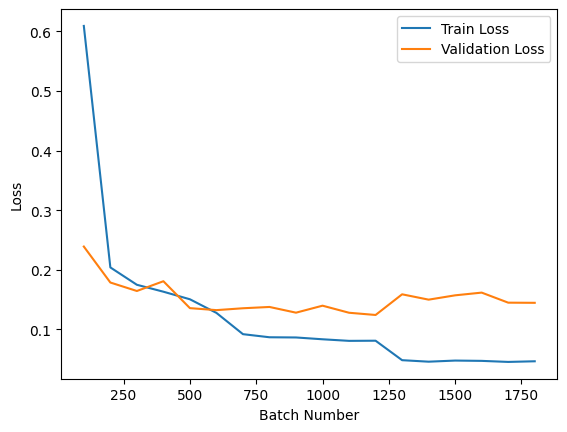

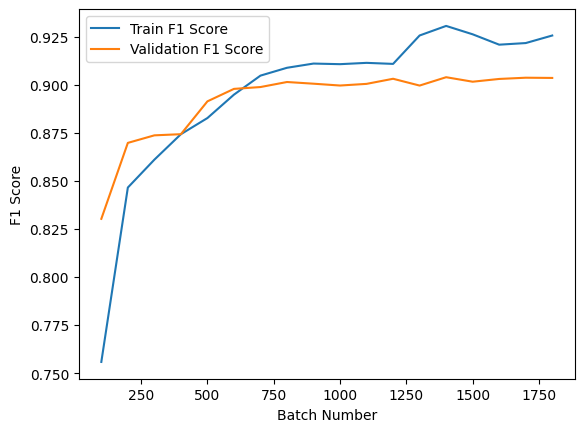

In [6]:
#plot the validation and training loss as well as f1 score
import matplotlib.pyplot as plt

save = False

f = plt.figure(1)
plt.plot(batch_num, train_losses, label = "Train Loss")
plt.plot(batch_num, val_losses, label = "Validation Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("TrainedModels/ModelMetrics/240embeddings-3encoder-8heads-64tokensize-loss.png") if save else None
f.show()

g = plt.figure(2)
plt.plot(batch_num, train_sample, label = "Train F1 Score")
plt.plot(batch_num, val_sample, label = "Validation F1 Score")
plt.xlabel("Batch Number")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("TrainedModels/ModelMetrics/240embeddings-3encoder-8heads-64tokensize-f1.png") if save else None
g.show()

#save the model
torch.save(transformer.state_dict(), "TrainedModels240embeddings-3encoder-8heads-64tokensize.pth") if save else None

# Running Tests

In [7]:
from sklearn.metrics import f1_score
#load the model

#model hyperparameters 
ntokens = 65536  # size of vocabulary
emsize = 240  # embedding dimension
d_hid = 240  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 3  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 4  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
threshold = 0.5 # threshold for binary classification

device = "cpu"
path = "TrainedModels/240embeddings-3encoder-4heads-64tokensize.pth"
model = RandomLM(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
criterion = nn.BCELoss().to(device)
model.load_state_dict(torch.load(path))

#run inferences on the test set
model.eval()
test_losses = []
micro_f1s = []
macro_f1s = []
sample_f1s = []
weighted_f1s = []
for i, data in enumerate(test_loader):
    queues, labels = data
    queues = queues.to(device)
    labels = labels.to(device)

    #forward pass
    output = model(queues)
    loss = criterion(output, labels)

    #metrics
    test_losses.append(loss.item())
    micro, macro, sample, weighted = F_score(output, labels, threshold)
    micro_f1s.append(micro)
    macro_f1s.append(macro)
    sample_f1s.append(sample)
    weighted_f1s.append(weighted)

print("Loss: ", np.array(test_losses).mean())
print("Micro F1 Score: ", np.array(micro_f1s).mean())
print("Macro F1 Score: ", np.array(macro_f1s).mean())
print("Sample F1 Score: ", np.array(sample_f1s).mean())
print("Weighted F1 Score: ", np.array(weighted_f1s).mean())

Loss:  0.06992334325737622
Micro F1 Score:  0.9819854437040001
Macro F1 Score:  0.9831217417807511
Sample F1 Score:  0.9225328355089016
Weighted F1 Score:  0.9831025695274198


# Inference